### 1. Load packages

In [1]:
import time

In [9]:
!pip install tinkoff-investments

  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached tinkoff-0.1.1-py3-none-any.whl.metadata (511 bytes)
Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
Using cached tinkoff-0.1.1-py3-none-any.whl (1.0 kB)


In [3]:
TOKEN = '' #боевой M13

In [5]:
from tinkoff.invest import Client
#from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX 


# with Client(TOKEN, target=INVEST_GRPC_API_SANDBOX ) as client:
#     print(client.users.get_accounts())


with Client(TOKEN) as client:
    print(client.users.get_accounts())

GetAccountsResponse(accounts=[Account(id='2169433725', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='M13', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2022, 4, 27, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_READ_ONLY: 2>)])


### 2. Load data

In [11]:
import logging
import os

import pandas as pd

from tinkoff.invest import Client, SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.utils import quotation_to_decimal



In [14]:
def get_figi(ticker):
    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)

        ticker_df = tickers_df[tickers_df["ticker"] == ticker]
        #return ticker_df
        if ticker_df.empty:
            print("There is no such ticker: %s", ticker)
            return

        figi = ticker_df["figi"].iloc[0]
        return figi

In [17]:
import os
from datetime import timedelta
import datetime

from tqdm import tqdm
import numpy as np

from tinkoff.invest import CandleInterval, Clientб AsyncClient
from tinkoff.invest.utils import now

    
def get_all_candles(ticker=None, from_=None, to_=None, interval=None):
    
    figi = get_figi(ticker)
    
    with Client(TOKEN) as client:
        
        data = [elem for elem in client.get_all_candles(figi=figi, 
                                      from_=from_-timedelta(hours=3),
                                      to=to_- timedelta(hours=3),
                                     interval=interval
                                    )
               ]

    
    open_ = np.zeros(len(data))
    high = np.zeros(len(data))
    low = np.zeros(len(data))
    close = np.zeros(len(data))
    volume = np.zeros(len(data))
    time = np.zeros(len(data), dtype='O')
    for i, elem in enumerate(data):
        open_[i] = quotation_to_decimal(elem.open)
        high[i] = quotation_to_decimal(elem.high)
        low[i] = quotation_to_decimal(elem.low)
        close[i] = quotation_to_decimal(elem.close)
        volume[i] = elem.volume
        time[i] = elem.time


    df = pd.DataFrame({'time' : time,
                      'open' : open_,
                      'close' : close,
                      'volume' : volume,
                      'low' : low,
                      'high' : high
                    })
    df['time'] += pd.Timedelta(hours=3)
    return df

In [26]:
%%time

ticker = 'SNGS'

data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2024, 12, 26, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 12, 27, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )

data['ticker'] = ticker

7it [00:00, 145347.17it/s]

CPU times: user 730 ms, sys: 18.8 ms, total: 749 ms
Wall time: 1.23 s


In [28]:
data

,time,open,close,volume,low,high,ticker
0,2024-12-26 07:00:00+00:00,23.590,23.780,20.0,23.590,23.780,SNGS
1,2024-12-26 08:00:00+00:00,23.780,23.665,2466.0,23.605,23.935,SNGS
2,2024-12-26 09:00:00+00:00,23.745,23.650,1028.0,23.650,23.815,SNGS
3,2024-12-26 10:00:00+00:00,23.650,24.295,237079.0,23.555,24.420,SNGS
4,2024-12-26 11:00:00+00:00,24.295,23.925,100329.0,23.910,24.405,SNGS
5,2024-12-26 12:00:00+00:00,23.910,24.050,44038.0,23.900,24.095,SNGS
6,2024-12-26 13:00:00+00:00,24.060,24.080,30359.0,23.945,24.120,SNGS


In [37]:
!mkdir data

mkdir: data: File exists


In [39]:
!mkdir data/raw

mkdir: data/raw: File exists


In [41]:
!mkdir data/raw/1min

mkdir: data/raw/1min: File exists


In [43]:
!mkdir data/raw/5min

mkdir: data/raw/5min: File exists


In [45]:
!mkdir data/raw/1hour

mkdir: data/raw/1hour: File exists


In [47]:
!mkdir data/raw/1day

mkdir: data/raw/1day: File exists


In [54]:
import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [61]:
stocks = [
    # 'GAZP',
    #       'SBER',
    #       'LKOH',
    #       'MGNT',
    #       'NVTK',
    #       'SNGS', 'SNGSP',
    #       'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',
          
          'YDEX',
          'CHMF',
          
          'MAGN',
          'T',
          'OZON',
          'RUAL'
          
         ]

for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 12, 26, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_1_MIN
                              )
            flag_data = True

        except:
            print('Error: flag_data')
            time.sleep(5)
            
    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1min/{stock}.pkl")


  0%|                                                                                  | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
59576it [00:00, 595742.10it/s]
119151it [00:00, 587521.42it/s]
178209it [00:00, 588899.46it/s]
237782it [00:00, 591579.48it/s]
297093it [00:00, 592127.43it/s]
356878it [00:00, 594065.18it/s]
416783it [00:00, 595692.41it/s]
476574it [00:00, 596393.86it/s]
536400it [00:00, 596974.84it/s]
629000it [00:01, 595190.28it/s]
  9%|██████▋                                                                  | 1/11 [02:25<24:18, 145.85s/it]
0it [00:00, ?it/s]
61216it [00:00, 612141.61it/s]
122431it [00:00, 606605.23it/s]
183096it [00:00, 606030.38it/s]
243701it [00:00, 601220.66it/s]
305005it [00:00, 605445.30it/s]
365654it [00:00, 605796.51it/s]
426239it [00:00, 605569.02it/s]
539732it [00:00, 603832.51it/s]
 18%|█████████████▎                                                           | 2/11 [03:57<17:05, 113.99s/it]
0it [00:00, ?it/s]
58922it [00:00, 589207.92it/s]
11903

In [63]:
#5min
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS', 'SNGSP',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',
          
          'YDEX',
          'CHMF',
          
          'MAGN',
          'T',
          'OZON',
          'RUAL'
          
         ]
for stock in tqdm(stocks):
    print(stock)

    
    flag_data1 = False
    while not flag_data1:
        try:
            data1 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2023, 10, 1, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                              )
            flag_data1 = True
        except:
            print('Error: flag_data1')
            time.sleep(5)

    
    flag_data2 = False
    while not flag_data2:
        try:            
            data2 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2023, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 10, 1, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                              )
            flag_data2 = True
        except:
            print('Error: flag_data2')
            time.sleep(5)

    
    flag_data3 = False
    while not flag_data3:
        try:            
            data3 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2024, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 12, 26, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_5_MIN
                              )
            flag_data3 = True
        except:
            print('Error: flag_data3')
            time.sleep(5)


    data = pd.concat([data1, data2, data3])
    data.sort_values(by='time', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/5min/{stock}.pkl")

  0%|                                                                                  | 0/19 [00:00<?, ?it/s]

GAZP



0it [00:00, ?it/s]
52680it [00:00, 467049.40it/s]

0it [00:00, ?it/s]
58429it [00:00, 525567.54it/s]

17171it [00:00, 412953.87it/s]
  5%|███▉                                                                      | 1/19 [01:20<24:01, 80.09s/it]

SBER



0it [00:00, ?it/s]
52579it [00:00, 485508.02it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
58435it [00:00, 538670.84it/s]

17188it [00:00, 415542.85it/s]
 11%|███████▊                                                                  | 2/19 [02:37<22:19, 78.78s/it]

LKOH


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52615it [00:00, 479507.60it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
58367it [00:00, 523184.34it/s]

17007it [00:00, 419966.25it/s]
 16%|███████████▋                                                              | 3/19 [04:39<26:11, 98.19s/it]

MGNT


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
51261it [00:00, 459670.02it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
55630it [00:00, 537051.79it/s]

15956it [00:00, 402949.76it/s]
 21%|███████████████▎                                                         | 4/19 [06:38<26:34, 106.32s/it]

NVTK


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52151it [00:00, 474107.65it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
57766it [00:00, 537602.18it/s]

16869it [00:00, 395577.12it/s]
 26%|███████████████████▏                                                     | 5/19 [08:37<25:55, 111.08s/it]

SNGS


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
47998it [00:00, 453752.54it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
54124it [00:00, 496187.02it/s]

14555it [00:00, 370203.84it/s]
 32%|███████████████████████                                                  | 6/19 [10:42<25:03, 115.69s/it]

SNGSP


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
49480it [00:00, 449234.40it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
55171it [00:00, 504929.08it/s]

16227it [00:00, 391164.00it/s]
 37%|██████████████████████████▉                                              | 7/19 [12:44<23:33, 117.78s/it]

GMKN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
49697it [00:00, 471343.96it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



55481it [00:00, 565740.11it/s]

16843it [00:00, 422586.69it/s]
 42%|██████████████████████████████▋                                          | 8/19 [14:38<21:22, 116.63s/it]

ROSN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52479it [00:00, 488680.37it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
58204it [00:00, 523590.83it/s]

17200it [00:00, 406917.68it/s]
 47%|██████████████████████████████████▌                                      | 9/19 [16:34<19:23, 116.32s/it]

NLMK


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
51791it [00:00, 466332.91it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
56975it [00:00, 524444.48it/s]

16646it [00:00, 407370.32it/s]
 53%|█████████████████████████████████████▉                                  | 10/19 [18:39<17:52, 119.14s/it]

TATN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52066it [00:00, 474220.92it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
57937it [00:00, 529153.74it/s]

16921it [00:00, 403216.89it/s]
 58%|█████████████████████████████████████████▋                              | 11/19 [20:38<15:53, 119.24s/it]

MTSS


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
51284it [00:00, 458433.54it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
57157it [00:00, 531733.92it/s]

16404it [00:00, 389600.02it/s]
 63%|█████████████████████████████████████████████▍                          | 12/19 [22:38<13:54, 119.22s/it]

ALRS


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52581it [00:00, 473187.15it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
57761it [00:00, 528990.77it/s]

16755it [00:00, 405359.55it/s]
 68%|█████████████████████████████████████████████████▎                      | 13/19 [24:40<12:00, 120.03s/it]

YDEX


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52586it [00:00, 494252.52it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



50851it [00:00, 511080.33it/s]

17057it [00:00, 415043.21it/s]
 74%|█████████████████████████████████████████████████████                   | 14/19 [26:40<10:00, 120.01s/it]

CHMF


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52144it [00:00, 459292.60it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
57806it [00:00, 510436.78it/s]

16679it [00:00, 402661.49it/s]
 79%|████████████████████████████████████████████████████████▊               | 15/19 [28:46<08:07, 122.00s/it]

MAGN


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52476it [00:00, 467526.59it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
57746it [00:00, 509461.85it/s]

16922it [00:00, 421891.14it/s]
 84%|████████████████████████████████████████████████████████████▋           | 16/19 [30:43<06:01, 120.45s/it]

T


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
41491it [00:00, 389725.91it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



49683it [00:00, 587415.38it/s]

17140it [00:00, 429938.05it/s]
 89%|████████████████████████████████████████████████████████████████▍       | 17/19 [32:36<03:56, 118.09s/it]

OZON


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



52579it [00:00, 547024.33it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
58289it [00:00, 543658.92it/s]

16924it [00:00, 401843.23it/s]
 95%|████████████████████████████████████████████████████████████████████▏   | 18/19 [34:33<01:57, 117.94s/it]

RUAL


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data1



0it [00:00, ?it/s]
52530it [00:00, 471183.44it/s]
None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data2



0it [00:00, ?it/s]
56779it [00:00, 521013.26it/s]

16042it [00:00, 387245.25it/s]
100%|████████████████████████████████████████████████████████████████████████| 19/19 [36:34<00:00, 115.49s/it]


In [65]:
#1hour
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                       from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 12, 26, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1hour/{stock}.pkl")

  0%|                                                                                  | 0/19 [00:00<?, ?it/s]
11415it [00:00, 301411.31it/s]
  5%|███▉                                                                      | 1/19 [00:07<02:08,  7.13s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



11406it [00:00, 301770.19it/s]
 11%|███████▊                                                                  | 2/19 [00:41<06:30, 22.98s/it]
11414it [00:00, 313872.95it/s]
 16%|███████████▋                                                              | 3/19 [00:48<04:13, 15.82s/it]
11353it [00:00, 571335.21it/s]
 21%|███████████████▌                                                          | 4/19 [00:55<03:05, 12.34s/it]
11320it [00:00, 309145.68it/s]
 26%|███████████████████▍                                                      | 5/19 [01:02<02:25, 10.43s/it]
11349it [00:00, 274560.81it/s]
 32%|███████████████████████▎                                                  | 6/19 [01:09<02:01,  9.37s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



11352it [00:00, 305194.76it/s]
 37%|███████████████████████████▎                                              | 7/19 [01:36<03:00, 15.08s/it]
11314it [00:00, 295457.75it/s]
 42%|███████████████████████████████▏                                          | 8/19 [01:43<02:15, 12.33s/it]
11382it [00:00, 310849.00it/s]
 47%|███████████████████████████████████                                       | 9/19 [01:50<01:47, 10.70s/it]
11355it [00:00, 323880.62it/s]
 53%|██████████████████████████████████████▍                                  | 10/19 [01:57<01:27,  9.67s/it]
11326it [00:00, 304404.05it/s]
 58%|██████████████████████████████████████████▎                              | 11/19 [02:04<01:11,  8.89s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



11353it [00:00, 281706.24it/s]
 63%|██████████████████████████████████████████████                           | 12/19 [02:37<01:52, 16.10s/it]
11382it [00:00, 305238.25it/s]
 68%|█████████████████████████████████████████████████▉                       | 13/19 [02:43<01:19, 13.23s/it]
10739it [00:00, 323055.30it/s]
 74%|█████████████████████████████████████████████████████▊                   | 14/19 [02:50<00:56, 11.35s/it]
11378it [00:00, 308665.62it/s]
 79%|█████████████████████████████████████████████████████████▋               | 15/19 [02:58<00:40, 10.06s/it]
11356it [00:00, 293785.22it/s]
 84%|█████████████████████████████████████████████████████████████▍           | 16/19 [03:05<00:27,  9.28s/it]None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data


None GetCandles RESOURCE_EXHAUSTED 


Error: flag_data



9725it [00:00, 274949.66it/s]
 89%|█████████████████████████████████████████████████████████████████▎       | 17/19 [03:37<00:32, 16.26s/it]
11395it [00:00, 309737.82it/s]
 95%|█████████████████████████████████████████████████████████████████████▏   | 18/19 [03:45<00:13, 13.50s/it]
11356it [00:00, 323671.43it/s]
100%|█████████████████████████████████████████████████████████████████████████| 19/19 [03:52<00:00, 12.23s/it]


In [67]:
#1day
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2022, 10, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 12, 26, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_DAY)
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1day/{stock}.pkl")

  0%|                                                                                  | 0/19 [00:00<?, ?it/s]
571it [00:00, 327044.60it/s]
  5%|███▉                                                                      | 1/19 [00:01<00:25,  1.42s/it]
571it [00:00, 362760.92it/s]
 11%|███████▊                                                                  | 2/19 [00:02<00:23,  1.38s/it]
571it [00:00, 379668.29it/s]
 16%|███████████▋                                                              | 3/19 [00:04<00:22,  1.38s/it]
571it [00:00, 372522.57it/s]
 21%|███████████████▌                                                          | 4/19 [00:05<00:20,  1.36s/it]
571it [00:00, 373393.76it/s]
 26%|███████████████████▍                                                      | 5/19 [00:06<00:19,  1.36s/it]
571it [00:00, 361446.96it/s]
 32%|███████████████████████▎                                                  | 6/19 [00:08<00:17,  1.37s/it]
571it [00:00, 322421.59it/s]
 37%|███████████████

### 3. Посмотрим на объемы торгов во времени

#### 3.1 По минутам

In [74]:
# 1 min

path = './data/raw/1min/NVTK.pkl'
df = load_pkl(path)
df['time'] = df['time'].apply(lambda x: x.tz_convert(None))

df

,time,open,close,volume,low,high,ticker
0,2022-10-03 09:59:00,978.0,978.0,1933.0,978.0,978.0,NVTK
1,2022-10-03 10:00:00,976.4,979.8,11255.0,975.8,982.2,NVTK
2,2022-10-03 10:01:00,979.8,977.0,11999.0,975.2,981.0,NVTK
3,2022-10-03 10:02:00,977.8,978.2,8573.0,976.2,980.0,NVTK
4,2022-10-03 10:03:00,977.8,979.4,6881.0,976.2,980.0,NVTK
...,...,...,...,...,...,...,...
579696,2024-12-25 23:45:00,930.0,930.8,271.0,929.8,930.8,NVTK
579697,2024-12-25 23:46:00,930.0,930.8,885.0,930.0,931.0,NVTK
579698,2024-12-25 23:47:00,931.0,929.8,966.0,929.8,931.2,NVTK
579699,2024-12-25 23:48:00,929.8,929.8,1604.0,929.4,930.8,NVTK


In [76]:
start = pd.Timestamp('2024-09-14')
end = pd.Timestamp('2024-09-15')

mask = (start <= df['time']) & (df['time'] < end)
mask.sum()

670

In [78]:
df_day= df.loc[mask, :]
df_day = df_day.set_index('time')
df_day

,open,close,volume,low,high,ticker
time,,,,,,
2024-09-14 07:02:00,967.4,967.0,54.0,967.0,967.4,NVTK
2024-09-14 07:03:00,969.0,969.0,5.0,969.0,969.0,NVTK
2024-09-14 07:04:00,967.0,967.0,2.0,967.0,967.0,NVTK
2024-09-14 07:05:00,967.0,968.8,3.0,967.0,968.8,NVTK
2024-09-14 07:06:00,968.6,968.6,3.0,968.6,968.6,NVTK
...,...,...,...,...,...,...
2024-09-14 23:37:00,972.8,972.8,1.0,972.8,972.8,NVTK
2024-09-14 23:39:00,972.8,973.0,54.0,972.8,973.0,NVTK
2024-09-14 23:40:00,973.0,971.0,42.0,971.0,973.0,NVTK


<Axes: xlabel='time'>

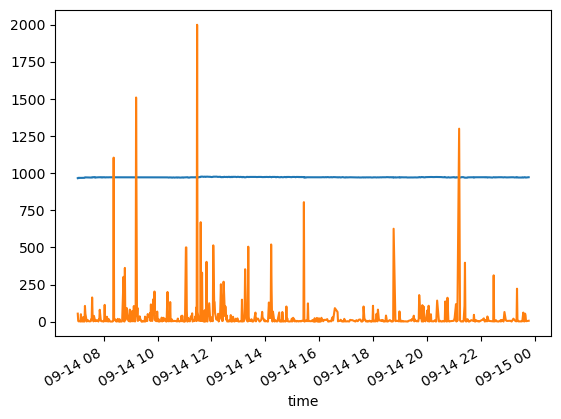

In [80]:
import matplotlib.pyplot as plt

df_day['close'].plot()
df_day['volume'].plot()
#plt.xticks(pd.date_range(pd.Timestamp('2024-11-4'), pd.Timestamp('2024-11-18'), freq='D'))

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_11126/4201550703.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()


<Axes: xlabel='time'>

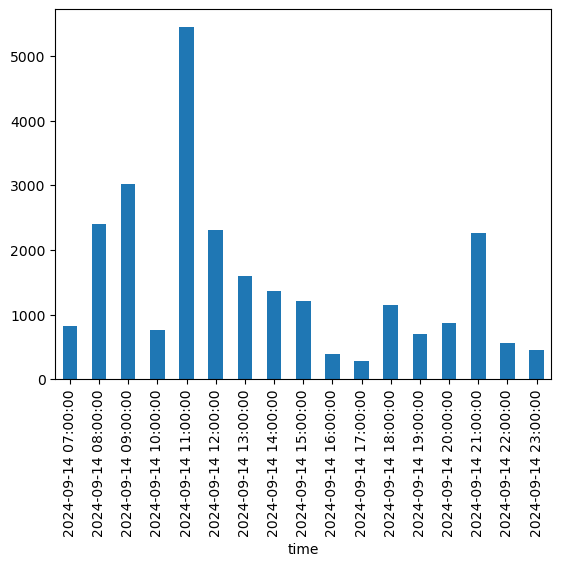

In [82]:
df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_11126/2747695137.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()


<Axes: xlabel='time'>

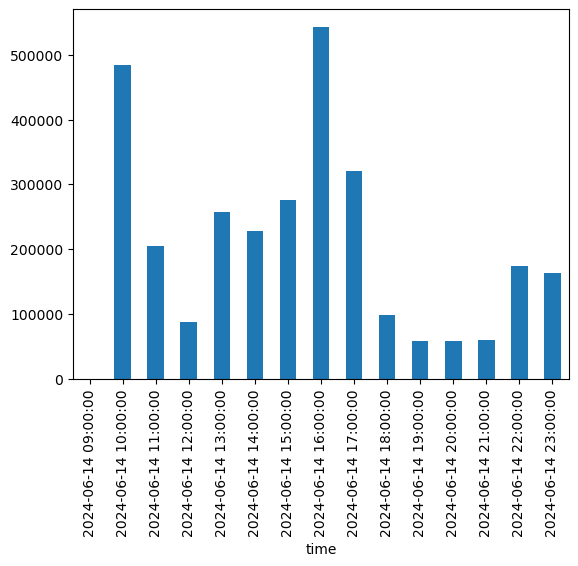

In [84]:
start = pd.Timestamp('2024-06-14')
end = pd.Timestamp('2024-06-15')

mask = (start <= df['time']) & (df['time'] < end)

df_day= df.loc[mask, :]
df_day = df_day.set_index('time')

df_day[['volume']].reset_index().groupby(pd.Grouper(key='time', freq='H')).volume.sum().plot.bar()

In [87]:
#Вывод: обрезать справа не будем, объемы есть

#### 3.1 По дням

In [91]:
path = './data/raw/1day/SBER.pkl'
df = load_pkl(path)
df['time'] = df['time'].apply(lambda x: x.tz_convert(None))

df

,time,open,close,volume,low,high,ticker
0,2022-09-30 03:00:00,111.00,110.21,13356904.0,103.40,113.40,SBER
1,2022-10-03 03:00:00,110.62,114.35,7396096.0,109.00,114.65,SBER
2,2022-10-04 03:00:00,115.06,110.55,8356468.0,110.30,115.50,SBER
3,2022-10-05 03:00:00,110.49,108.51,9041692.0,106.25,110.49,SBER
4,2022-10-06 03:00:00,108.65,108.24,5174148.0,107.57,110.38,SBER
...,...,...,...,...,...,...,...
566,2024-12-19 03:00:00,230.16,229.00,12406137.0,227.71,234.99,SBER
567,2024-12-20 03:00:00,229.10,257.60,23518622.0,228.03,258.98,SBER
568,2024-12-23 03:00:00,260.00,264.90,16316565.0,256.51,270.00,SBER
569,2024-12-24 03:00:00,264.94,264.34,8380866.0,261.02,266.79,SBER


In [93]:
start = pd.Timestamp('2024-10-1')
end = pd.Timestamp('2024-10-31')

mask = (start <= df['time']) & (df['time'] < end)
mask.sum()

22

In [95]:
df_month= df.loc[mask, :]
df_month = df_month.set_index('time')
df_month

,open,close,volume,low,high,ticker
time,,,,,,
2024-10-01 03:00:00,267.60,266.29,5212580.0,264.00,268.68,SBER
2024-10-02 03:00:00,266.01,259.31,4651920.0,258.52,268.00,SBER
2024-10-03 03:00:00,259.31,264.25,5653456.0,257.20,264.49,SBER
2024-10-04 03:00:00,264.96,264.09,2599229.0,262.11,265.44,SBER
2024-10-07 03:00:00,264.25,263.39,2894060.0,261.37,267.00,SBER
2024-10-08 03:00:00,263.00,262.40,1616378.0,261.89,263.80,SBER
2024-10-09 03:00:00,262.42,260.86,2502135.0,259.59,263.80,SBER
2024-10-10 03:00:00,260.88,259.98,1767723.0,258.91,261.64,SBER
2024-10-11 03:00:00,259.80,256.94,2484858.0,256.80,260.07,SBER


<Axes: xlabel='time'>

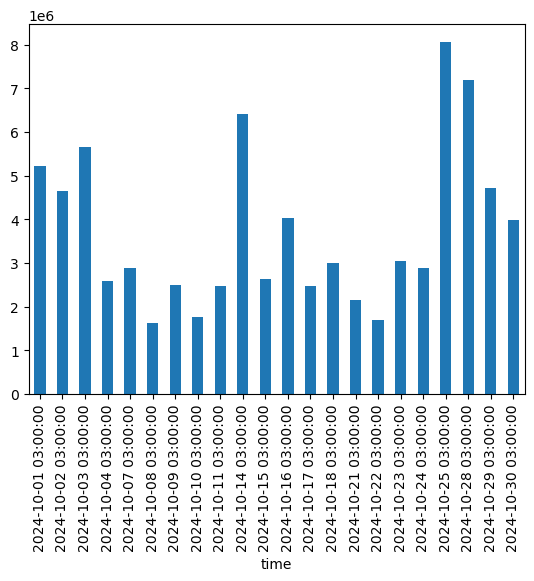

In [97]:
import matplotlib.pyplot as plt

#df_day['close'].plot()
df_month['volume'].plot.bar()
#plt.xticks(pd.date_range(start, end, freq='D'))

In [99]:
#Выходных нет, это хорошо, так как они внутри тинька идут, а не на биржи

### 4. Preproc data

* Оставляем только будни
* И часы основных торгов - 10:00–23, но на вечерних торгх тоже есть объемы, было бы глупо их не учитывать, поэтому 10:00–24:00

In [107]:
!mkdir data/preproc

mkdir: data/preproc: File exists


In [109]:
!mkdir data/preproc/1min

mkdir: data/preproc/1min: File exists


In [111]:
!mkdir data/preproc/5min

mkdir: data/preproc/5min: File exists


In [113]:
!mkdir data/preproc/1hour

mkdir: data/preproc/1hour: File exists


In [115]:
!mkdir data/preproc/1day

mkdir: data/preproc/1day: File exists


In [118]:
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

def preproc(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data
                                         

    

In [124]:
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS', 'SNGSP',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',  
          'YDEX',
          'CHMF',
          
          'MAGN',
          'T',
          'OZON',
          'RUAL'  
         ]

for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1min/{stock}.pkl")

    data = preproc(data)
    
    dump_pkl(data, f"./data/preproc/1min/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 19/19 [02:04<00:00,  6.55s/it]


In [126]:
#5min
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/5min/{stock}.pkl")

    data = preproc(data)
    
    dump_pkl(data, f"./data/preproc/5min/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:28<00:00,  1.53s/it]


In [128]:
#1hour
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1hour/{stock}.pkl")

    data = preproc(data)
    
    dump_pkl(data, f"./data/preproc/1hour/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.98it/s]


In [130]:
def preproc_day_data(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    #mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    #data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data


#1day
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1day/{stock}.pkl")

    data = preproc_day_data(data)
    
    dump_pkl(data, f"./data/preproc/1day/{stock}.pkl")

100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.79it/s]


# 

In [138]:
1

1

### 5. Анализ на целостность данных

In [142]:
#проверить на заполняемость

#### 5.1 1min

In [145]:
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS', 'SNGSP',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',  
          'YDEX',
          'CHMF',
          
          'MAGN',
          'T',
          'OZON',
          'RUAL'  
         ]

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1min/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

 21%|███████████████▌                                                          | 4/19 [00:00<00:00, 33.78it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
SNGSP
GMKN


 68%|█████████████████████████████████████████████████▉                       | 13/19 [00:00<00:00, 39.51it/s]

ROSN
NLMK
TATN
MTSS
ALRS
YDEX
CHMF
MAGN
T
OZON


100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.28it/s]

RUAL


In [147]:
#Нет дублей и данные отсортированы

In [150]:
#Заполняеимость

In [152]:
stocks = [
          'GAZP',
          'SBER',
          'LKOH',
          'MGNT',
          'NVTK',
          'SNGS', 'SNGSP',
          'GMKN',
          'ROSN',
          'NLMK',
          'TATN',
          'MTSS',
          'ALRS',  
          'YDEX',
          'CHMF',
          
          'MAGN',
          'T',
          'OZON',
          'RUAL'  
         ]


dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1min/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('1 min')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.99it/s]


(8666393, 8)

In [154]:
df['diff'].value_counts().sort_values(ascending=False).iloc[:20]

diff
1.0       8499799
2.0        106236
3.0         18190
6.0         11638
15.0         8657
611.0        8430
4.0          5208
3491.0       2070
5.0          2006
16.0         1431
7.0           479
17.0          454
8.0           291
9.0           203
18.0          171
19.0          126
10.0          121
612.0         102
11.0           91
901.0          66
Name: count, dtype: int64

<Axes: xlabel='diff'>

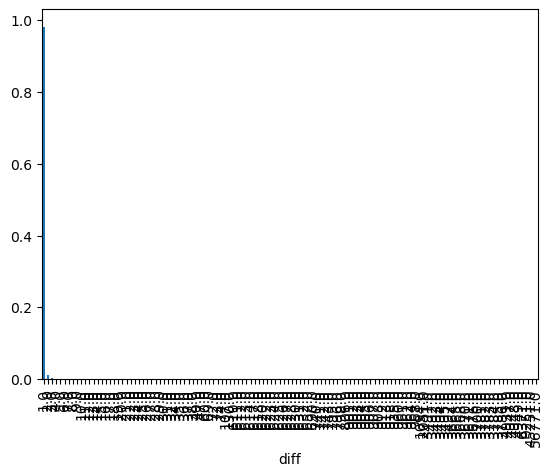

In [156]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [158]:
threshold = 2
(df['diff'] < 2).mean(), (df['diff'] < 3).mean(), (df['diff'] < 15).mean()

(0.9807770083816878, 0.9930353954638337, 0.9974642276204183)

In [160]:
#Отличные результаты (тут еще смена дня не учтена и выходные)

#### 5.2 5min

In [164]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/5min/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 125.12it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
SNGSP
GMKN
ROSN
NLMK
TATN
MTSS
ALRS
YDEX
CHMF
MAGN
T
OZON
RUAL


In [166]:
#Нет дублей и данные отсортированы

In [169]:
#Заполняемость

In [171]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/5min/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('5 min')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 246.30it/s]


(1777831, 8)

<Axes: xlabel='diff'>

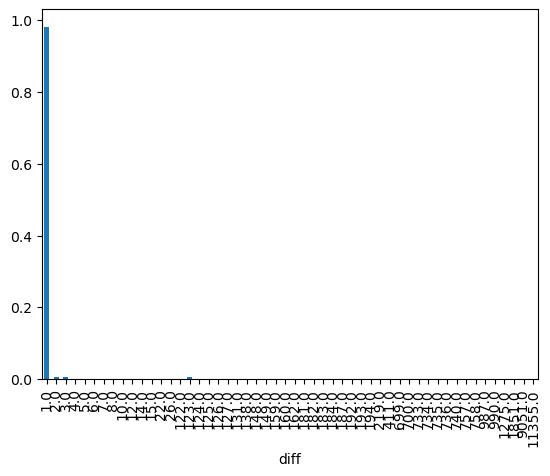

In [173]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [175]:
threshold = 2
(df['diff'] < 2).mean(), (df['diff'] < 3).mean(), (df['diff'] < 12).mean()

(0.9809858192370365, 0.9875820592621009, 0.9937823111420602)

In [177]:
#Отлично (тут еще смена дня не учтена и выходные)

#### 5.3 1hour

In [182]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 439.17it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
SNGSP
GMKN
ROSN
NLMK
TATN
MTSS
ALRS
YDEX
CHMF
MAGN
T
OZON
RUAL


In [184]:
#Нет дублей и данные отсортированы

In [187]:
#Заполняемость

In [189]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('1 hour')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1108.06it/s]


(152890, 8)

<Axes: xlabel='diff'>

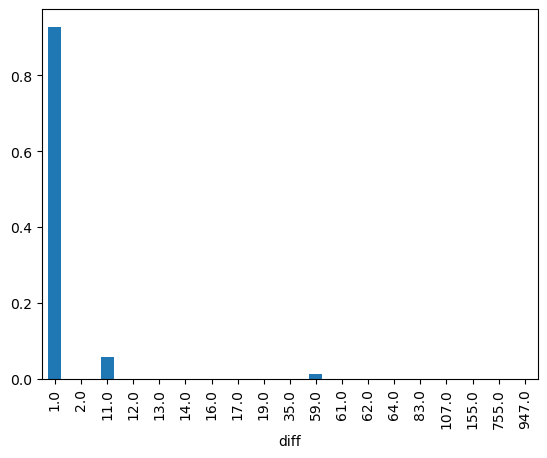

In [191]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [193]:
threshold = 2
((df['diff'] < 2) | (df['diff'] == 11) | (df['diff'] == 59)).mean()

0.9980051017071097

In [195]:
#Отлично (не все выходные еще учтены)

#### 5.4 1day

In [200]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    print(stock)
    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    

100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 879.78it/s]

GAZP
SBER
LKOH
MGNT
NVTK
SNGS
SNGSP
GMKN
ROSN
NLMK
TATN
MTSS
ALRS
YDEX
CHMF
MAGN
T
OZON
RUAL


In [202]:
#Нет дублей и данные отсортированы

In [205]:
#Заполняемость

In [207]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('24 hours')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1058.49it/s]


(10761, 8)

<Axes: xlabel='diff'>

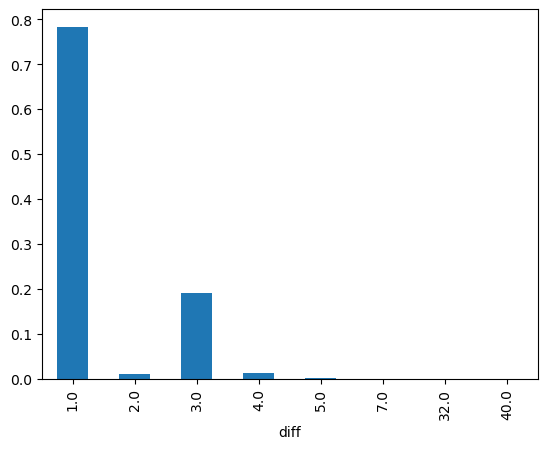

In [209]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [211]:
threshold = 2
(df['diff'] < 4).mean(), (df['diff'] < 5).mean()

(0.9840163553573088, 0.9961899451723818)

In [213]:
#Отлично